In [28]:
import astropy
print(astropy.__version__)

import pandas as pd
import os
import requests
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import simple_norm


5.2.2
1.26.4


In [23]:
  def read_fits_data_header(path, ext=1):
        """
        Fallback: astropy.getdata/getheader with memmap disabled.
        """
        data = fits.getdata(path, ext=ext, memmap=False)
        header = fits.getheader(path, ext=ext)
        data = np.array(data, copy=True).astype(float)
        blank = header.get('BLANK', None)
        if blank is not None:
            data[data == blank] = np.nan
        return data, header

# C/2009 F2

In [24]:
# -----------------------------
# User settings / inputs
# -----------------------------
fi_dir = "data/C2009F2/Pan-STARRS1"
eph_file = "data/visible2/C_2009F2_visible.csv"

df = pd.read_csv(eph_file)
col_inst = "Telescope/Instrument"
inst = "Pan-STARRS1"
df = df[df[col_inst] == inst]

# RA/DEC columns (you said Object_RA/Object_Dec)
col_ra, col_dec = "Object_RA", "Object_Dec"
col_img = "Image"

# other columns to display
col_exptime = "Exptime"
col_m1 = "M1"
col_m2 = "M2"


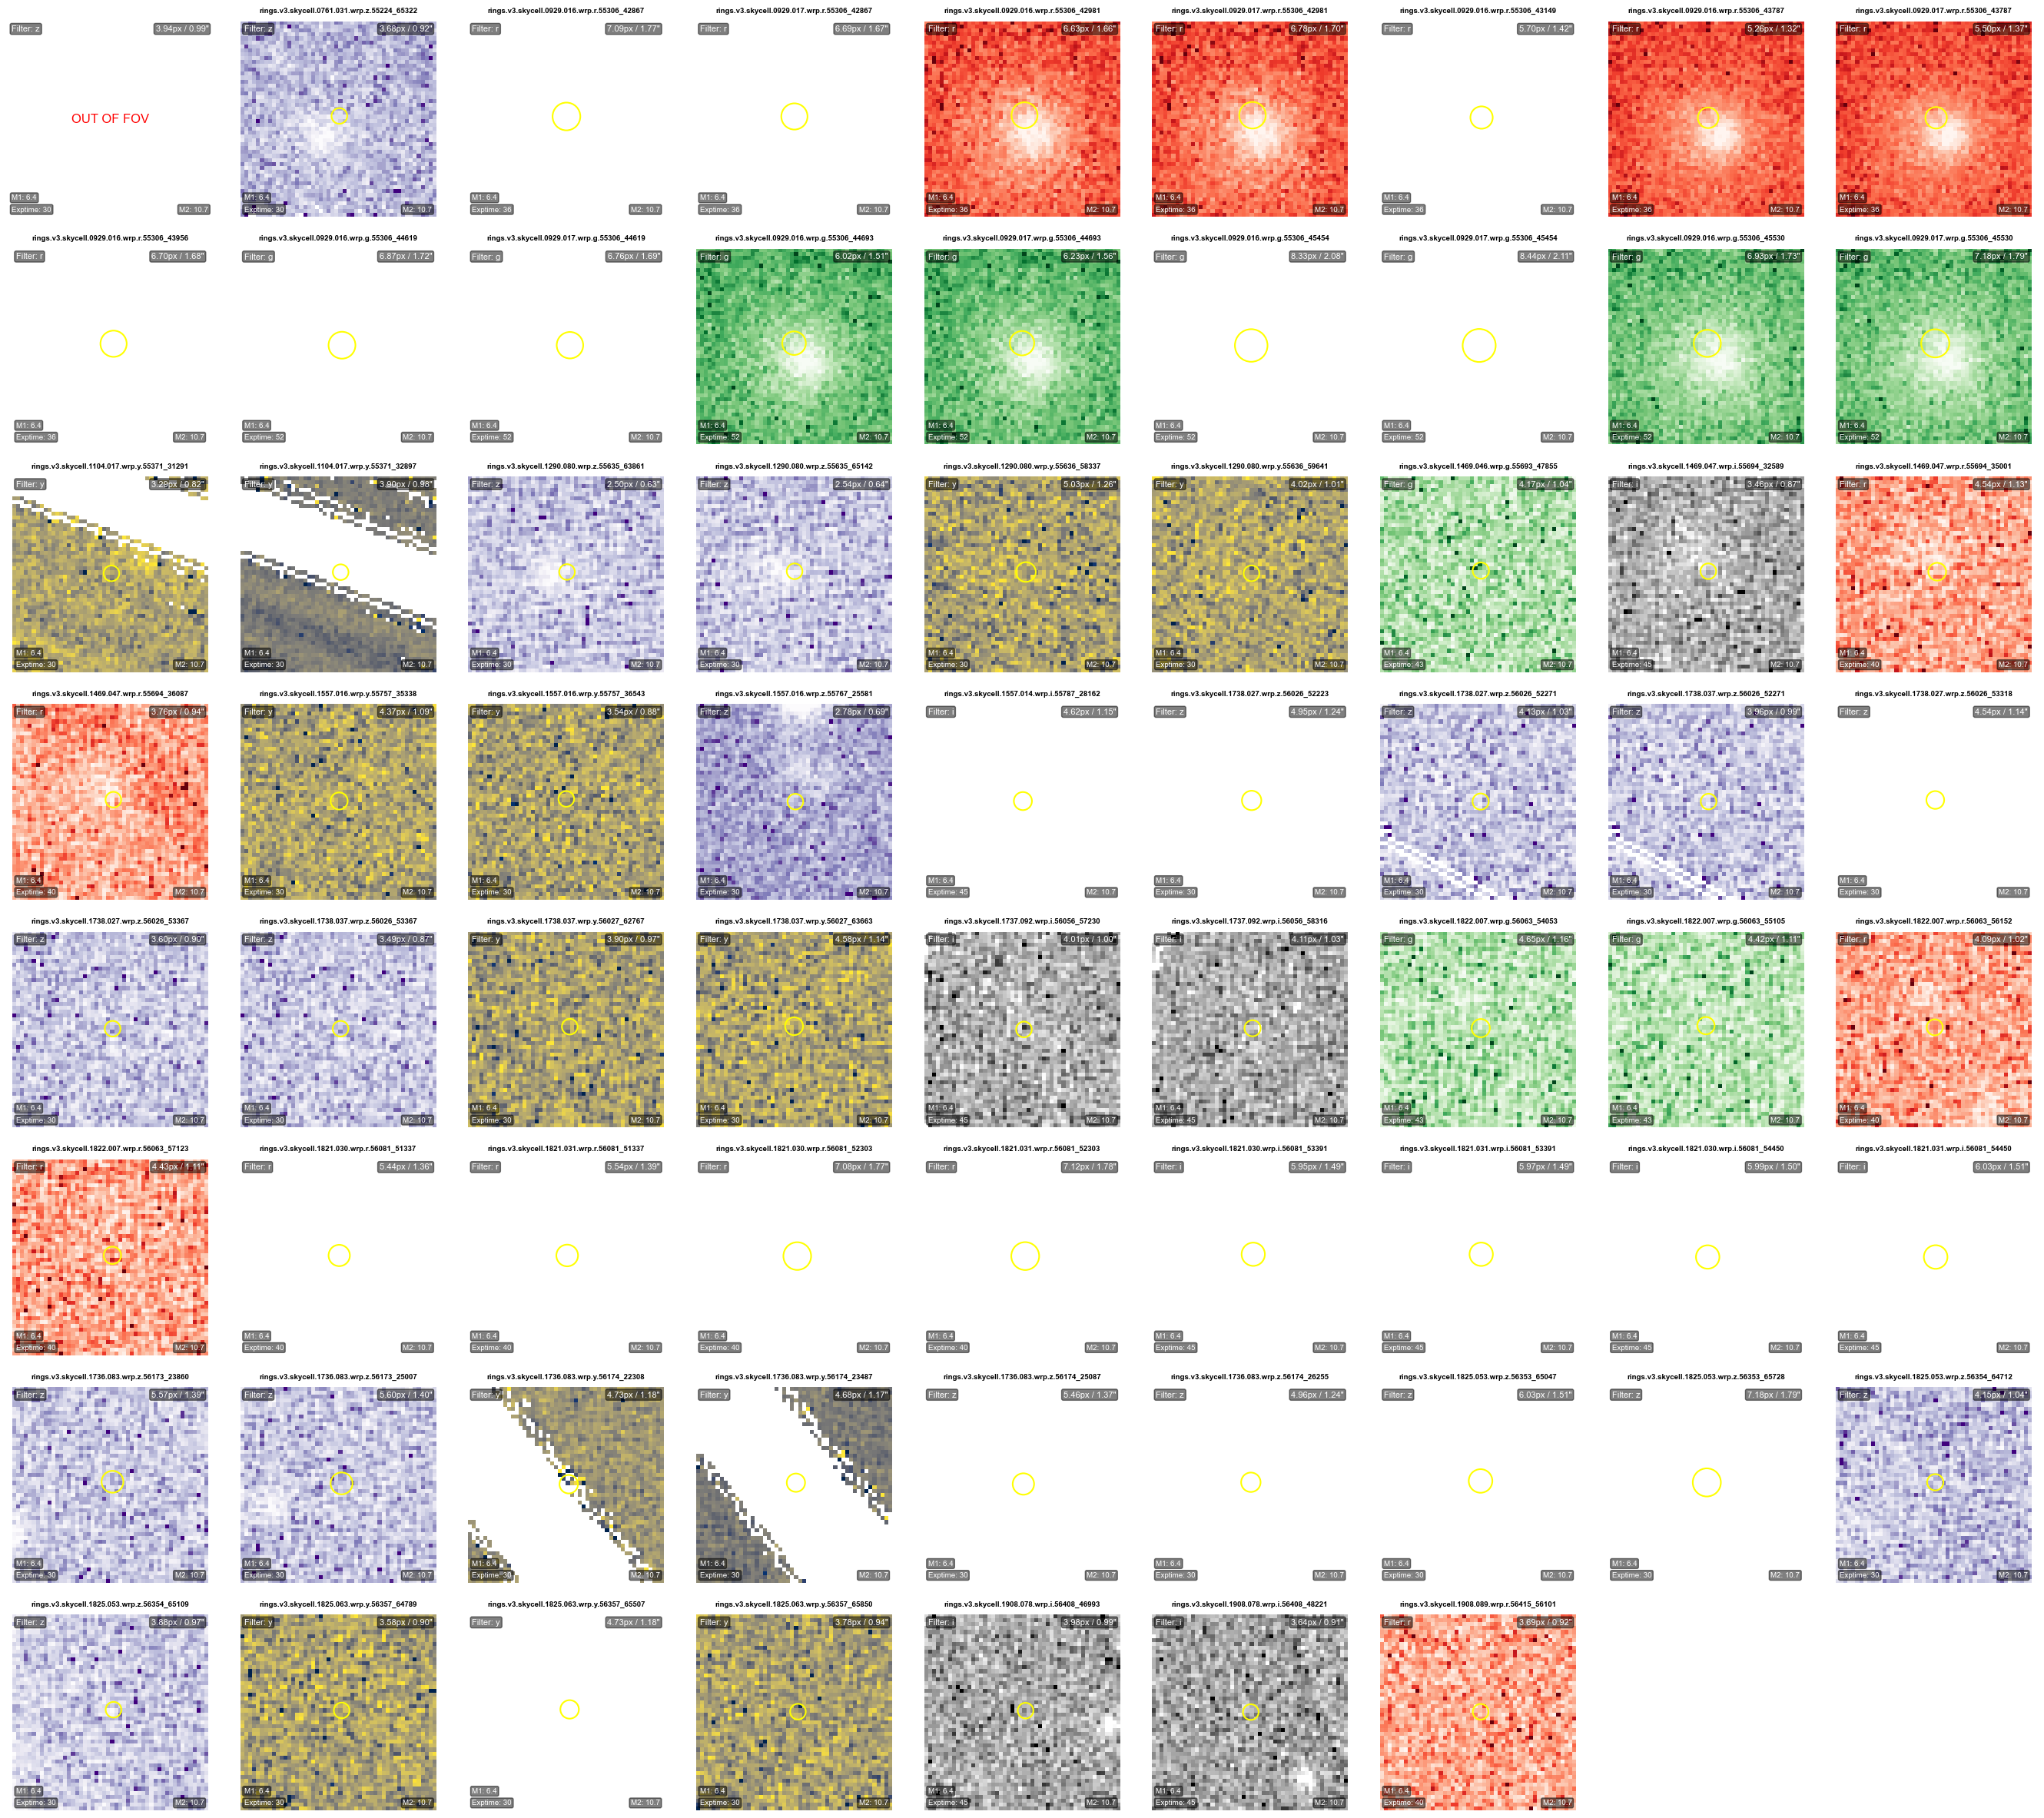

In [31]:
# display settings
max_plots = 70
n_plots = min(len(df), max_plots)
n_cols = math.ceil(math.sqrt(n_plots))
n_rows = math.ceil(n_plots / n_cols)

cut_size = 50  # pixels (square)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
axes = axes.flatten()

# cmap mapping by band letter (lowercase)
cmap_map = {
    'g': 'Greens_r',
    'r': 'Reds_r',
    'i': 'gray',
    'z': 'Purples_r',
    'y': 'cividis',
}
default_cmap = 'gray'


bbox = dict(boxstyle="round,pad=0.2", fc="black", alpha=0.5)


# iterate
for idx, row in enumerate(df.itertuples()):
    if idx >= n_plots:
        break

    ax = axes[idx]
    ra = getattr(row, col_ra)
    dec = getattr(row, col_dec)
    image_name = getattr(row, col_img)
    fits_path = os.path.join(fi_dir, image_name) + ".fits"

    # If file missing
    if not os.path.exists(fits_path):
        ax.text(0.5, 0.5, 'File not found', ha='center', va='center', fontsize=10)
        ax.axis('off')
        continue

    try:
        data, header = read_fits_data_header(fits_path, ext=1)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error reading FITS\n{e}", ha='center', va='center', fontsize=8)
        ax.axis('off')
        continue

    # Build WCS from header (use header of image HDU)
    try:
        wcs = WCS(header)
    except Exception:
        wcs = None

    # get pixel scale (arcsec/pix) from CDELT1 if present, else fallback to 0.258
    cdelt1 = header.get('CDELT1', None)
    if cdelt1 is not None:
        pixscale = abs(cdelt1) * 3600.0
    else:
        # fallback typical PS1 ~0.258 arcsec/pix
        pixscale = 0.258

    # header values for annotations
    seeing_pix = header.get("HIERARCH CHIP.SEEING", None)
    filt_hdr = header.get("HIERARCH FPA.FILTER", None)
    # normalize filter string to single letter if possible (e.g. 'i.00000 ' -> 'i')
    band = None
    if isinstance(filt_hdr, str) and len(filt_hdr.strip()) > 0:
        # try to find letter among characters
        s = filt_hdr.strip()
        # pick first alphabetic char
        for ch in s:
            if ch.isalpha():
                band = ch.lower()
                break
    # choose cmap
    cmap_name = cmap_map.get(band, default_cmap)

    # try to convert ra/dec to pixel; handle missing WCS gracefully
    out_of_fov = False
    try:
        x, y = wcs.wcs_world2pix(ra, dec, 0)
    except Exception:
        # try using astropy.coordinates as fallback
        try:
            from astropy.coordinates import SkyCoord
            from astropy import units as u
            sky = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
            x, y = wcs.world_to_pixel(sky)
        except Exception:
            x, y = -1, -1

    # check out-of-range BEFORE casting to int
    if (x < 0) or (y < 0) or (x >= data.shape[1]) or (y >= data.shape[0]):
        out_of_fov = True

    if out_of_fov:
        # still annotate header info for user
        ax.text(0.5, 0.5, 'OUT OF FOV', ha='center', va='center', fontsize=12, color='red')
        # annotate filter / seeing / exptime / M1/M2 in corners (if present)
        if band is not None:
            ax.text(0.02, 0.98, f"Filter: {band}", color='w', fontsize=8, ha='left', va='top', transform=ax.transAxes, bbox=bbox)
        if seeing_pix is not None:
            seeing_arc = seeing_pix * pixscale
            ax.text(0.98, 0.98, f"{seeing_pix:.2f}px / {seeing_arc:.2f}\"", color='w', fontsize=8, ha='right', va='top', transform=ax.transAxes, bbox=bbox)
        # Exptime, M1, M2 from df (row)
        exptime = getattr(row, col_exptime, None)
        m1 = getattr(row, col_m1, None)
        m2 = getattr(row, col_m2, None)
        if exptime is not None:
            ax.text(0.02, 0.02, f"Exptime: {exptime}", color='w', fontsize=7, ha='left', va='bottom', transform=ax.transAxes, bbox=bbox)
        if m1 is not None:
            ax.text(0.02, 0.08, f"M1: {m1}", color='w', fontsize=7, ha='left', va='bottom', transform=ax.transAxes, bbox=bbox)
        if m2 is not None:
            ax.text(0.98, 0.02, f"M2: {m2}", color='w', fontsize=7, ha='right', va='bottom', transform=ax.transAxes, bbox=bbox)

        ax.axis('off')
        continue

    # now cast pixel indices to ints and get cutout bounds
    xi = int(np.round(x))
    yi = int(np.round(y))

    y_min = max(yi - cut_size//2, 0)
    y_max = min(yi + cut_size//2, data.shape[0])
    x_min = max(xi - cut_size//2, 0)
    x_max = min(xi + cut_size//2, data.shape[1])
    cutout = data[y_min:y_max, x_min:x_max]

    # image normalization for display
    try:
        norm = simple_norm(cutout, 'sqrt', percent=99)
    except Exception:
        norm = None

    im = ax.imshow(cutout, origin='lower', cmap=cmap_name, norm=norm)
    ax.axis('off')
    ax.set_title(image_name, fontsize=7)

    # draw predicted position as circle (in cutout coords)
    x_cut = x - x_min
    y_cut = y - y_min
    # choose radius: 4 pix or seeing_pix/2 whichever >0
    try:
        radius = 4
        if seeing_pix is not None and seeing_pix > 0:
            radius = max(2, min(seeing_pix/2.0, 8))
    except Exception:
        radius = 4
    circ = Circle((x_cut, y_cut), radius=radius, edgecolor='yellow', facecolor='none', linewidth=1.5)
    ax.add_patch(circ)

    # annotate filter upper-left
    if band is not None:
        ax.text(0.02, 0.98, f"Filter: {band}", color='w', fontsize=8,
                ha='left', va='top', transform=ax.transAxes, bbox=bbox)

    # annotate seeing upper-right (pix / arcsec)
    if seeing_pix is not None:
        seeing_arc = seeing_pix * pixscale
        ax.text(0.98, 0.98, f"{seeing_pix:.2f}px / {seeing_arc:.2f}\"", color='w', fontsize=8,
                ha='right', va='top', transform=ax.transAxes, bbox=bbox)

    # Exptime, M1 left-bottom; M2 right-bottom
    exptime = getattr(row, col_exptime, None)
    m1 = getattr(row, col_m1, None)
    m2 = getattr(row, col_m2, None)
    if exptime is not None:
        ax.text(0.02, 0.02, f"Exptime: {exptime}", color='w', fontsize=7, ha='left', va='bottom', transform=ax.transAxes, bbox=bbox)
    if m1 is not None:
        ax.text(0.02, 0.08, f"M1: {m1}", color='w', fontsize=7, ha='left', va='bottom', transform=ax.transAxes, bbox=bbox)
    if m2 is not None:
        ax.text(0.98, 0.02, f"M2: {m2}", color='w', fontsize=7, ha='right', va='bottom', transform=ax.transAxes, bbox=bbox)

# hide unused axes
for ax in axes[n_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# C/2008 FK75

In [ ]:
fi_dir = "data/C2008FK75/Pan-STARRS1"
eph_dir = "data/visible2/C_2008FK75_visible.csv"

In [26]:
scan = os.scandir('data/cadc2/')
files = [entry.path for entry in scan if entry.is_file()]
files.sort()

comet_name = "_".join(files[idx].split('/')[-1].split('.')[0].split('_')[:-1])
print(f'Processing comet: {comet_name}')
df_cadc = pd.read_csv(files[idx])
df_jplh = pd.read_csv(f'data/jpl2/{comet_name}_jplhorizons.csv')
df_merged = pd.merge(df_cadc, df_jplh, left_index=True, right_index=True, suffixes=('_cadc', '_jplh'))

# Select observations with DECam
df_decam = df_merged[df_merged['Telescope/Instrument'] == 'CTIO-4m/DECam']
df_decam

Processing comet: C_2005 T3


,Image,MJD,Filter,Exptime,Object_RA,Object_Dec,Image_target,Telescope/Instrument,MetaData,Datalink,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
204,dec065029.fits.fz 4b051f5a04ba287e08ef1f0cd27e...,56382.167005,z,100,176.552271,5.521695,17740571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,11575727.30,0.214723,8737.28,31755.23,77.224940,196.3285,NaN,2.4140,232.4198,-2.3519
205,tu1705735.fits.fz e8ed9e0b81afffad907bb79d2eb8...,56382.167005,unknown,100,176.552271,5.521695,17740571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,11620000.20,0.214771,8677.23,31536.98,77.520297,196.3632,NaN,2.5055,232.5003,-2.3560
206,c4d_130331_035939_ooi_z_v1.fits.fz f089ebca947...,56382.167005,z,100,176.552271,5.521695,17740571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,11663974.00,0.214818,8615.10,31311.20,77.813658,196.3979,NaN,2.5966,232.5805,-2.3601
207,c4d_130331_035939_opi_z_v1.fits.fz 198f84ae3ae...,56382.167005,z,100,176.552271,5.521695,17740571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,11707637.20,0.214864,8550.89,31077.82,78.104948,196.4326,NaN,2.6871,232.6604,-2.3643
208,c4d_130331_035939_ooi_z_ls11.fits.fz 1a75fc39a...,56382.167005,z,100,176.552271,5.521695,17740571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,11750978.50,0.214909,8484.59,30836.86,78.394090,196.4674,NaN,2.7771,232.7401,-2.3685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,c4d_250528_101650_ori.fits.fz ea91c87fde969207...,60823.428655,r,50,11.828088,2.610616,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,7748889.71,0.126279,4174.99,15173.81,51.695028,260.5465,NaN,3.4168,298.2969,-6.7030
1867,c4d_250528_101650_oki_r_v1.fits.fz ad1b0c5f8ce...,60823.428655,r,50,11.828088,2.610616,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,7727029.05,0.126072,4206.04,15286.67,51.549189,260.5931,NaN,3.2965,298.2806,-6.7066
1868,c4d_250528_101650_ooi_r_v1.fits.fz 1d4258ac0c3...,60823.428655,r,50,11.828088,2.610616,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,7705024.54,0.125862,4235.87,15395.07,51.402391,260.6396,NaN,3.1755,298.2637,-6.7101
1869,c4d_250528_101650_opi_r_v1.fits.fz e39f78a7478...,60823.428655,r,50,11.828088,2.610616,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,7682882.53,0.125651,4264.47,15499.01,51.254675,260.6862,NaN,3.0538,298.2463,-6.7135


In [28]:
# df_decam['date'] = df_decam['Image'].apply(lambda x: "_".join(x.split('_')[:3]))

# gr = df_decam.groupby('date')

# for i, (name, group) in enumerate(gr):
#     display(group)
#     cond = group['Image'].str.contains('_ooi')
#     group_filtered = group[cond]
#     if len(group_filtered) > 1:
#         if group_filtered['Image'].str.contains('_v2').any():
#             display(group_filtered[group_filtered['Image'].str.contains('_v2')])
#         elif group_filtered['Image'].str.contains('_v1').any():
#             display(group_filtered[group_filtered['Image'].str.contains('_v1')])
#         elif group_filtered['Image'].str.contains('_v3').any():
#             display(group_filtered[group_filtered['Image'].str.contains('_v3')])
#         elif group_filtered['Image'].str.contains('_v4').any():
#             display(group_filtered[group_filtered['Image'].str.contains('_v4')])
#         else:
#             display(group_filtered.iloc[[0]])
#     else:
#         display(group_filtered)

#     if i == 10:
#         break


In [34]:
def select_decam_images(group):
    # Select only calibrated images containing '_ooi'
    cond = group['Image'].str.contains('_ooi') | group['Image'].str.contains('_opi')
    group_filtered = group[cond]
    # If both _opi and _ooi exist, prefer _opi
    if group_filtered['Image'].str.contains('_opi').any():
        group_filtered = group_filtered[group_filtered['Image'].str.contains('_opi')]
    if len(group_filtered) > 1:
        if group_filtered['Image'].str.contains('_v4').any():
            return group_filtered[group_filtered['Image'].str.contains('_v4')]
        elif group_filtered['Image'].str.contains('_v3').any():
            return group_filtered[group_filtered['Image'].str.contains('_v3')]
        elif group_filtered['Image'].str.contains('_v2').any():
            return group_filtered[group_filtered['Image'].str.contains('_v2')]
        elif group_filtered['Image'].str.contains('_v1').any():
            return group_filtered[group_filtered['Image'].str.contains('_v1')]
        else:
            return group_filtered.iloc[[0]]
    else:
        return group_filtered

cond = df_decam['Image'].str.startswith('c4d_')
df_decam = df_decam[cond].reset_index(drop=True)

# Recompute grouping key
df_decam['date'] = df_decam['Image'].apply(lambda x: "_".join(x.split('_')[:3]))
gr = df_decam.groupby('date')

# Silence DeprecationWarning by excluding grouping columns from the groups
try:
    df_selected = gr.apply(select_decam_images, include_groups=False)
except TypeError:
    # Fallback for older pandas without include_groups parameter
    df_selected = gr.apply(select_decam_images)

df_selected

,,Image,MJD,Filter,Exptime,Object_RA,Object_Dec,Image_target,Telescope/Instrument,MetaData,Datalink,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
date,,,,,,,,,,,,,,,,,,,,,,
c4d_130331_035939,1,c4d_130331_035939_opi_z_v1.fits.fz 198f84ae3ae...,56382.167005,z,100,176.552271,5.521695,17740571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,11707637.20,0.214864,8550.89,31077.82,78.104948,196.4326,NaN,2.6871,232.6604,-2.3643
c4d_130331_040147,4,c4d_130331_040147_opi_z_v1.fits.fz 89e4d7bfddf...,56382.168488,z,100,176.552151,5.521737,17560571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,11920903.10,0.215077,8199.36,29800.18,79.527705,196.6063,NaN,3.1312,233.0557,-2.3855
c4d_130401_050330,7,c4d_130401_050330_opi_z_v1.fits.fz a2f7a3421a7...,56383.211351,z,100,176.467855,5.551133,17640500.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,12124798.40,0.215261,7802.62,28358.27,80.887948,196.7800,NaN,3.5587,233.4426,-2.4076
c4d_130403_051438,10,c4d_130403_051438_opi_z_v1.fits.fz 7c221762d0e...,56385.219077,z,100,176.307586,5.606397,17560571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,12318166.30,0.215417,7365.92,26771.09,82.177960,196.9537,NaN,3.9673,233.8199,-2.4304
c4d_140416_041445,13,c4d_140416_041445_ooi_r_a1.fits.fz 7948e1bfaaf...,56763.176136,r,30,188.495494,-1.341289,PMap20140415-O9,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,10384629.00,0.203251,11028.68,40083.24,69.278787,201.8970,NaN,0.4250,236.8377,-3.2086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4d_250107_010035,1016,c4d_250107_010035_opi_r_v1.fits.fz d091b75c1f8...,60682.042277,r,35,349.870923,-7.766219,twilight3,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,8092840.99,0.129480,3486.73,12672.37,53.989624,259.7565,NaN,5.2805,298.4623,-6.6222
c4d_250528_094005,1020,c4d_250528_094005_opi_r_v1.fits.fz 4cca63a6c37...,60823.403128,r,50,11.824766,2.609162,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,7997782.89,0.128606,3715.03,13502.09,53.355464,259.9886,NaN,4.7756,298.4378,-6.6493
c4d_250528_095220,1025,c4d_250528_095220_opi_r_v1.fits.fz 5d7955ab699...,60823.411637,r,50,11.825873,2.609646,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,7897360.34,0.127675,3924.43,14263.16,52.685517,260.2209,NaN,4.2317,298.3922,-6.6738


In [30]:
df_limits = pd.read_csv("data/Survey-Filter-LimitingMagnitude-SaturationMagnitude-TypicalExposureTime.csv")
df_limits

,Telescope/Instrument,Filter,Limiting,Saturation,Exposure
0,Pan-STARRS1,g,21.5,14.5,45
1,Pan-STARRS1,r,21.5,14.5,45
2,Pan-STARRS1,i,21.5,14.5,45
3,Pan-STARRS1,z,20.9,14.5,45
4,Pan-STARRS1,y,19.7,14.5,45
5,SDSS,g,23.3,14.0,54
6,SDSS,u,22.3,14.0,54
7,SDSS,r,23.1,14.0,54
8,SDSS,i,22.3,14.0,54
9,SDSS,z,20.8,14.0,54


In [35]:
# Keep only needed columns
limits = df_limits[[c for c in ['Telescope/Instrument', 'Filter', 'Limiting', 'Saturation'] if c in df_limits.columns]].dropna(subset=['Telescope/Instrument'])

# Keep only observations whose Telescope/Instrument exists in the limits
valid_instr = set(limits['Telescope/Instrument'].unique())
df_merged = df_selected[df_selected['Telescope/Instrument'].isin(valid_instr)].copy()

# Attach limits to each observation; inner keeps only matched (Instrument, Filter)
df_with_limits = df_merged.merge(limits, on=['Telescope/Instrument', 'Filter'], how='inner')

# Condition: not saturated (Tmag >= Saturation) and not too faint (Tmag <= Limiting)
cond = (df_with_limits['Tmag'] >= df_with_limits['Saturation']) & (df_with_limits['Tmag'] <= df_with_limits['Limiting'])

df_visible = df_with_limits[cond]
df_visible

,Image,MJD,Filter,Exptime,Object_RA,Object_Dec,Image_target,Telescope/Instrument,MetaData,Datalink,...,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat,Limiting,Saturation
0,c4d_130331_035939_opi_z_v1.fits.fz 198f84ae3ae...,56382.167005,z,100,176.552271,5.521695,17740571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,8550.89,31077.82,78.104948,196.4326,NaN,2.6871,232.6604,-2.3643,23.7,16.0
1,c4d_130331_040147_opi_z_v1.fits.fz 89e4d7bfddf...,56382.168488,z,100,176.552151,5.521737,17560571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,8199.36,29800.18,79.527705,196.6063,NaN,3.1312,233.0557,-2.3855,23.7,16.0
2,c4d_130401_050330_opi_z_v1.fits.fz a2f7a3421a7...,56383.211351,z,100,176.467855,5.551133,17640500.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,7802.62,28358.27,80.887948,196.7800,NaN,3.5587,233.4426,-2.4076,23.7,16.0
3,c4d_130403_051438_opi_z_v1.fits.fz 7c221762d0e...,56385.219077,z,100,176.307586,5.606397,17560571.0,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,7365.92,26771.09,82.177960,196.9537,NaN,3.9673,233.8199,-2.4304,23.7,16.0
4,c4d_140416_041445_ooi_r_a1.fits.fz 7948e1bfaaf...,56763.176136,r,30,188.495494,-1.341289,PMap20140415-O9,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,11028.68,40083.24,69.278787,201.8970,NaN,0.4250,236.8377,-3.2086,23.7,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,c4d_250107_010035_opi_r_v1.fits.fz d091b75c1f8...,60682.042277,r,35,349.870923,-7.766219,twilight3,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,3486.73,12672.37,53.989624,259.7565,NaN,5.2805,298.4623,-6.6222,23.7,16.0
261,c4d_250528_094005_opi_r_v1.fits.fz 4cca63a6c37...,60823.403128,r,50,11.824766,2.609162,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,3715.03,13502.09,53.355464,259.9886,NaN,4.7756,298.4378,-6.6493,23.7,16.0
262,c4d_250528_095220_opi_r_v1.fits.fz 5d7955ab699...,60823.411637,r,50,11.825873,2.609646,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,3924.43,14263.16,52.685517,260.2209,NaN,4.2317,298.3922,-6.6738,23.7,16.0
263,c4d_250528_100435_opi_r_v1.fits.fz e189d57ba2b...,60823.420146,r,50,11.826981,2.610131,FMa02,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,4109.22,14934.79,51.983657,260.4534,NaN,3.6549,298.3275,-6.6953,23.7,16.0


In [24]:
idx = 0
href = df_decam.iloc[idx]['MetaData']

In [ ]:
from astropy.utils.data import conf

# Set cache folder for astropy downloads
conf.dataurl = 'https://astroarchive.noirlab.edu/api/retrieve/'
conf.remote_timeout = 30
hdul = fits.open(href, cache=True, memmap=False)

NameError: name 'href' is not defined

In [15]:
hdul.info()

Filename: /home/asergeiev/.astropy/cache/download/url/271f93f97879d407cacb37861a44ed8f/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     160   ()      
  1  S1            1 CompImageHDU    102   (2160, 4146)   int16   
  2  S2            1 CompImageHDU    102   (2160, 4146)   int16   
  3  S3            1 CompImageHDU    102   (2160, 4146)   int16   
  4  N1            1 CompImageHDU    102   (2160, 4146)   int16   
  5  N2            1 CompImageHDU    102   (2160, 4146)   int16   
  6  N3            1 CompImageHDU    102   (2160, 4146)   int16   
  7  S8            1 CompImageHDU    102   (2160, 4146)   int16   
  8  S9            1 CompImageHDU    102   (2160, 4146)   int16   
  9  S14           1 CompImageHDU    102   (2160, 4146)   int16   
 10  S15           1 CompImageHDU    102   (2160, 4146)   int16   
 11  S20           1 CompImageHDU    102   (2160, 4146)   int16   
 12  S25           1 CompImageHDU    102   (2160, 4146

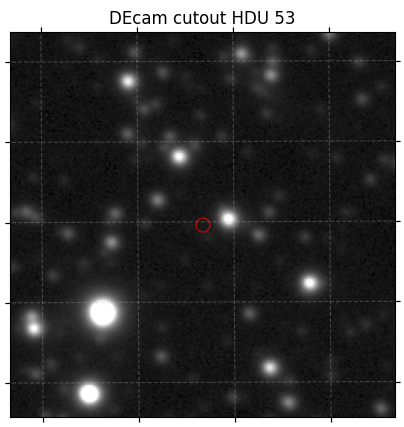

In [ ]:
def cutout_decam(hdul, idx):

    coord = SkyCoord(df_decam.iloc[idx]['Object_RA']*u.deg, df_decam.iloc[idx]['Object_Dec']*u.deg, frame='icrs')
    for i, hdu in enumerate(hdul):
        if i == 0:
            continue
        w = WCS(hdu.header)
        ny, nx = hdu.data.shape
        x_pix, y_pix = w.world_to_pixel(coord)
        in_fov = (0 <= x_pix < nx) and (0 <= y_pix < ny)
        
        if in_fov:
            size = u.Quantity((1, 1), u.arcmin)
            cutout = Cutout2D(hdu.data, (x_pix, y_pix), size, wcs=w)
            
            hdu_out = fits.PrimaryHDU(data=cutout.data, header=cutout.wcs.to_header())
            out_filename = f'./comets/fits/decam_cutout_{idx}_hdu{i}.fits'
            if os.path.exists('./comets/fits/') is False:
                os.makedirs('./comets/fits/')
                
            hdu_out.writeto(out_filename, overwrite=True)
            print(f'Wrote cutout to {out_filename}')    
            
            fig = plt.figure(figsize=(5, 5))
            ax = fig.add_subplot(1, 1, 1, projection=cutout.wcs)
            norm = simple_norm(cutout.data, 'sqrt', percent=99.)
            ax.imshow(cutout.data, origin='lower', cmap='gray', norm=norm,
                    )
            ax.scatter(cutout.wcs.world_to_pixel(coord)[0], cutout.wcs.world_to_pixel(coord)[1],
                    s=100, edgecolor='red', facecolor='none', marker='o', lw=1, alpha=0.7)
            ax.set_title(f'DEcam cutout HDU {i}')
            # WCSAxes niceties
            ax.set_xlabel("RA")
            ax.set_ylabel("Dec")
            ax.coords.grid(True, alpha=0.3, linestyle="--")
            plt.show()
# hdul.close()